# Maximum Likelihood Estimation of Silverstein Density Parameters

This notebook performs systematic parameter estimation for the theoretical Silverstein spectral density curve against ReLU-mapped CIFAR-10 eigenvalue data.

Instead of fitting parameters by eye (as in `fig_gen.ipynb`), we use:
1. **Coarse grid search** over $(\alpha, L_c)$ to map the loss landscape
2. **Fine grid search** to refine the estimate
3. **Nelder-Mead optimization** for final MLE values

The aspect ratio $q = M/T$ is fixed by the data dimensions.

## Setup

In [25]:
import sys
sys.path.insert(0, 'src')

from powerlawdata.solver import silverstein_density, end_pts
from powerlawdata.datasets import load_cifar10

import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import os
from time import time
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Load CIFAR-10 and Compute ReLU-Mapped Eigenvalues

Eigenvalues are cached to `data/cifar_relu_10k_eigs.npy` to avoid recomputation.

In [ ]:
CACHE_PATH = "data/cifar_relu_10k_eigs.npy"
NReLU = 10000
T = 50000
M = NReLU
q = M / T  # 0.2

if os.path.exists(CACHE_PATH):
    print("Loading cached ReLU eigenvalues...")
    eigs_relu = np.load(CACHE_PATH)
else:
    print("Computing ReLU-mapped CIFAR eigenvalues (this takes a couple minutes)...")
    X_CIFAR = load_cifar10({"data_dir": "data", "split": "train"})
    Xtr = torch.tensor(X_CIFAR).to(dtype=torch.float64, device=device)

    u = torch.randn((NReLU, 32*32*3), dtype=torch.float64, device=device)
    XReLU = torch.nn.ReLU()(Xtr @ u.T / NReLU)
    Xcent = XReLU - XReLU.mean(axis=0)
    CRel = Xcent.T @ Xcent / Xcent.shape[0]
    eigs_relu = np.array(sorted(torch.linalg.eigvalsh(CRel).cpu().numpy())[::-1])

    np.save(CACHE_PATH, eigs_relu)
    print(f"Saved eigenvalues to {CACHE_PATH}")

print(f"M = {M}, T = {T}, q = {q}")
print(f"Number of eigenvalues: {len(eigs_relu)}")
print(f"Eigenvalue range: [{eigs_relu[eigs_relu > 0].min():.2e}, {eigs_relu[0]:.2e}]")

## Empirical Spectrum

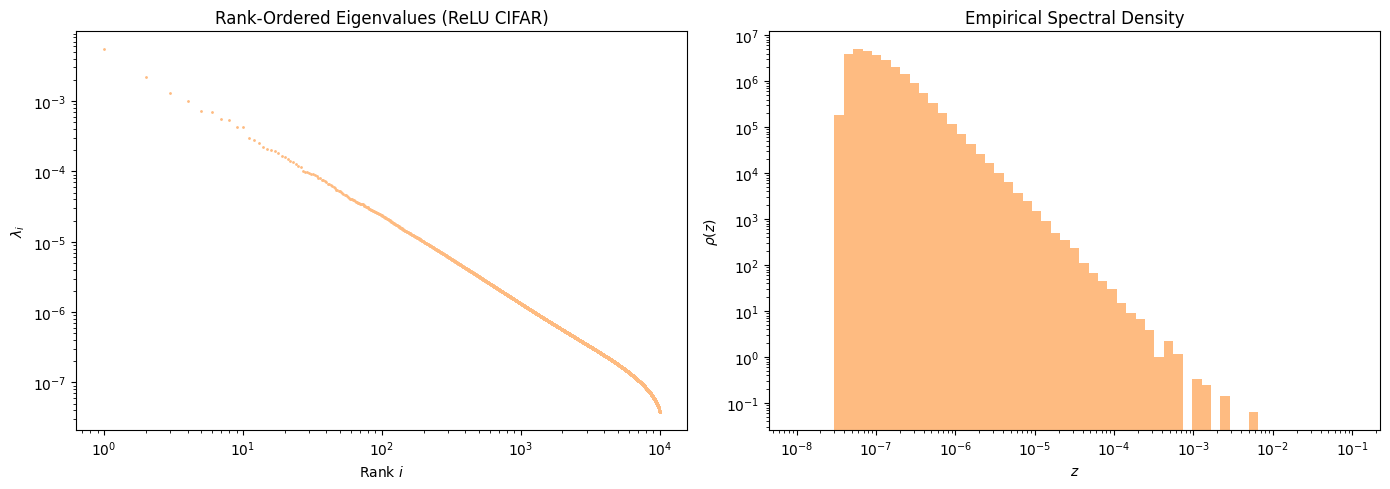

In [61]:
sns.set_palette("magma_r")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].loglog(range(1, len(eigs_relu)+1), eigs_relu, ".", markersize=2)
axes[0].set_xlabel(r"Rank $i$")
axes[0].set_ylabel(r"$\lambda_i$")
axes[0].set_title("Rank-Ordered Eigenvalues (ReLU CIFAR)")

bins_plot = np.logspace(-8, -1, 60)
axes[1].hist(eigs_relu, bins=bins_plot, density=True)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(r"$z$")
axes[1].set_ylabel(r"$\rho(z)$")
axes[1].set_title("Empirical Spectral Density")

plt.tight_layout()
plt.show()

## Loss Function

We bin the empirical eigenvalues and compute the theoretical Silverstein density at the bin midpoints. The loss is the **L2 distance in log-space** between the empirical histogram density and the theoretical density, restricted to the valid support of the theory curve:

$$\mathcal{L}(\alpha, L_c) = \frac{1}{N_{\text{bins}}} \sum_{i \in \text{support}} \left(\log_{10} \hat{\rho}_i - \log_{10} \rho_i(\alpha, L_c)\right)^2$$

This is equivalent to least-squares regression on the log-log plot and is a natural choice for power-law distributed data.

In [62]:
# Set up histogram bins for loss computation
N_LOSS_BINS = 60
Z_MAX = 5e-5  # only consider z <= Z_MAX in the optimization
eig_min = max(eigs_relu[eigs_relu > 0].min(), 1e-10)
eig_max = eigs_relu[0]
loss_bin_edges = np.logspace(np.log10(eig_min), np.log10(eig_max), N_LOSS_BINS + 1)
hist_counts, _ = np.histogram(eigs_relu, bins=loss_bin_edges)
hist_density, _ = np.histogram(eigs_relu, bins=loss_bin_edges, density=True)
bin_midpoints = np.sqrt(loss_bin_edges[:-1] * loss_bin_edges[1:])  # geometric midpoints
bin_widths = loss_bin_edges[1:] - loss_bin_edges[:-1]

print(f"Loss bins: {N_LOSS_BINS} bins from {eig_min:.2e} to {eig_max:.2e}")
print(f"Non-empty bins: {(hist_counts > 0).sum()}")
print(f"Bins with z <= Z_MAX: {(bin_midpoints <= Z_MAX).sum()}")


def compute_loss(alpha, log_Lc, q):
    """
    Compute L2 log-space loss between theoretical Silverstein density
    and the empirical eigenvalue histogram, restricted to z <= Z_MAX.
    """
    Lc = 10**log_Lc
    if Lc >= 1 or Lc <= 0 or alpha <= 0:
        return np.inf

    # Solver expects evals ordered largest-to-smallest
    evals = bin_midpoints[::-1]
    try:
        num_density = silverstein_density(evals, alpha=alpha, q=q, Lc=Lc)
    except Exception:
        return np.inf

    rho = np.abs(num_density[::-1])  # reverse back to match bin order

    # Build dict for end_pts
    rho_dict = {}
    for z, r in zip(evals, num_density):
        if r is not None:
            rho_dict[z] = abs(r)
    if len(rho_dict) < 10:
        return np.inf

    try:
        zL, zR = end_pts(rho_dict)
    except Exception:
        return np.inf

    # Valid bins: within support, z <= Z_MAX, nonzero empirical and theoretical density
    valid = ((bin_midpoints >= zL) & (bin_midpoints <= min(zR, Z_MAX)) &
             (hist_density > 0) & (rho > 1e-30) & ~np.isnan(rho))

    if valid.sum() < 5:
        return np.inf

    log_hist = np.log10(hist_density[valid])
    log_rho = np.log10(rho[valid])
    return np.mean((log_hist - log_rho)**2)

Loss bins: 60 bins from 3.81e-08 to 5.40e-03
Non-empty bins: 52
Bins with z <= Z_MAX: 36


### Sanity check: loss at the by-eye parameters

In [63]:
alpha_eye = 1.23
Lc_eye = 6.45e-3 * M**(-alpha_eye)
log_Lc_eye = np.log10(Lc_eye)

print(f"By-eye parameters: alpha = {alpha_eye}, Lc = {Lc_eye:.4e}, log10(Lc) = {log_Lc_eye:.3f}")

t0 = time()
loss_eye = compute_loss(alpha_eye, log_Lc_eye, q)
dt = time() - t0

print(f"By-eye loss: {loss_eye:.6f}")
print(f"Time per evaluation: {dt:.1f}s")

By-eye parameters: alpha = 1.23, Lc = 7.7546e-08, log10(Lc) = -7.110
By-eye loss: 0.000650
Time per evaluation: 1.1s


## Coarse Grid Search

Search over a broad range of $(\alpha, \log_{10} L_c)$ to map out the loss landscape.

In [64]:
alpha_coarse = np.linspace(0.8, 1.7, 10)
log_Lc_coarse = np.linspace(-10, -4, 10)
n_evals = len(alpha_coarse) * len(log_Lc_coarse)

print(f"Coarse grid: {len(alpha_coarse)} x {len(log_Lc_coarse)} = {n_evals} evaluations")

loss_coarse = np.full((len(alpha_coarse), len(log_Lc_coarse)), np.inf)
t0 = time()

for i, alpha in enumerate(alpha_coarse):
    for j, log_Lc in enumerate(log_Lc_coarse):
        loss_coarse[i, j] = compute_loss(alpha, log_Lc, q)
    elapsed = time() - t0
    per_row = elapsed / (i + 1)
    remaining = per_row * (len(alpha_coarse) - i - 1)
    print(f"  alpha = {alpha:.2f} done ({i+1}/{len(alpha_coarse)}), "
          f"~{remaining/60:.1f} min remaining")

best_idx = np.unravel_index(np.nanargmin(loss_coarse), loss_coarse.shape)
best_alpha_c = alpha_coarse[best_idx[0]]
best_log_Lc_c = log_Lc_coarse[best_idx[1]]

print(f"\nCoarse optimum: alpha = {best_alpha_c:.3f}, log10(Lc) = {best_log_Lc_c:.3f}")
print(f"  Lc = {10**best_log_Lc_c:.3e}")
print(f"  Loss = {loss_coarse[best_idx]:.6f}")
print(f"Total time: {(time()-t0)/60:.1f} min")

Coarse grid: 10 x 10 = 100 evaluations
  alpha = 0.80 done (1/10), ~1.3 min remaining
  alpha = 0.90 done (2/10), ~1.2 min remaining
  alpha = 1.00 done (3/10), ~1.1 min remaining
  alpha = 1.10 done (4/10), ~0.9 min remaining
  alpha = 1.20 done (5/10), ~0.8 min remaining
  alpha = 1.30 done (6/10), ~0.6 min remaining
  alpha = 1.40 done (7/10), ~0.5 min remaining
  alpha = 1.50 done (8/10), ~0.3 min remaining
  alpha = 1.60 done (9/10), ~0.2 min remaining
  alpha = 1.70 done (10/10), ~0.0 min remaining

Coarse optimum: alpha = 1.400, log10(Lc) = -7.333
  Lc = 4.642e-08
  Loss = 0.012519
Total time: 1.6 min


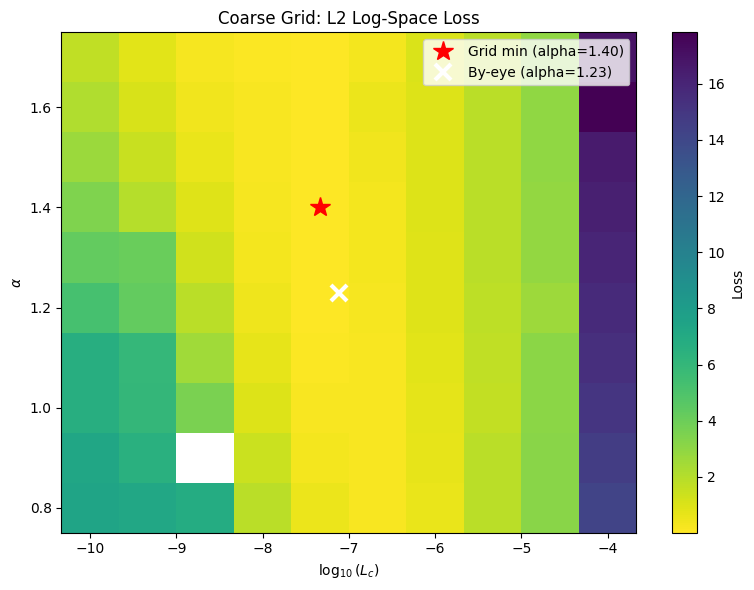

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_grid = loss_coarse.copy()
plot_grid[~np.isfinite(plot_grid)] = np.nan

im = ax.pcolormesh(log_Lc_coarse, alpha_coarse, plot_grid,
                    shading='auto', cmap='viridis_r')
ax.plot(best_log_Lc_c, best_alpha_c, 'r*', markersize=15,
        label=f'Grid min (alpha={best_alpha_c:.2f})')
ax.plot(log_Lc_eye, alpha_eye, 'wx', markersize=12, mew=3,
        label=f'By-eye (alpha={alpha_eye})')
ax.set_xlabel(r"$\log_{10}(L_c)$")
ax.set_ylabel(r"$\alpha$")
ax.set_title("Coarse Grid: L2 Log-Space Loss")
plt.colorbar(im, ax=ax, label="Loss")
ax.legend()
plt.tight_layout()
plt.savefig("figures/mle_coarse_grid.png", dpi=150)
plt.show()

## Fine Grid Search

Refine the search around the coarse optimum.

In [66]:
# Zoom in: +/- 1.5 coarse grid spacings around the optimum
da = (alpha_coarse[1] - alpha_coarse[0]) * 1.5
dl = (log_Lc_coarse[1] - log_Lc_coarse[0]) * 1.5

alpha_fine = np.linspace(best_alpha_c - da, best_alpha_c + da, 12)
log_Lc_fine = np.linspace(best_log_Lc_c - dl, best_log_Lc_c + dl, 12)
n_evals = len(alpha_fine) * len(log_Lc_fine)

print(f"Fine grid: {len(alpha_fine)} x {len(log_Lc_fine)} = {n_evals} evaluations")
print(f"  alpha in [{alpha_fine[0]:.3f}, {alpha_fine[-1]:.3f}]")
print(f"  log10(Lc) in [{log_Lc_fine[0]:.3f}, {log_Lc_fine[-1]:.3f}]")

loss_fine = np.full((len(alpha_fine), len(log_Lc_fine)), np.inf)
t0 = time()

for i, alpha in enumerate(alpha_fine):
    for j, log_Lc in enumerate(log_Lc_fine):
        loss_fine[i, j] = compute_loss(alpha, log_Lc, q)
    elapsed = time() - t0
    per_row = elapsed / (i + 1)
    remaining = per_row * (len(alpha_fine) - i - 1)
    print(f"  alpha = {alpha:.3f} done ({i+1}/{len(alpha_fine)}), "
          f"~{remaining/60:.1f} min remaining")

best_idx_f = np.unravel_index(np.nanargmin(loss_fine), loss_fine.shape)
best_alpha_f = alpha_fine[best_idx_f[0]]
best_log_Lc_f = log_Lc_fine[best_idx_f[1]]

print(f"\nFine optimum: alpha = {best_alpha_f:.4f}, log10(Lc) = {best_log_Lc_f:.4f}")
print(f"  Lc = {10**best_log_Lc_f:.4e}")
print(f"  Loss = {loss_fine[best_idx_f]:.6f}")
print(f"Total time: {(time()-t0)/60:.1f} min")

Fine grid: 12 x 12 = 144 evaluations
  alpha in [1.250, 1.550]
  log10(Lc) in [-8.333, -6.333]
  alpha = 1.250 done (1/12), ~2.5 min remaining
  alpha = 1.277 done (2/12), ~2.3 min remaining
  alpha = 1.305 done (3/12), ~2.0 min remaining
  alpha = 1.332 done (4/12), ~1.8 min remaining
  alpha = 1.359 done (5/12), ~1.6 min remaining
  alpha = 1.386 done (6/12), ~1.3 min remaining
  alpha = 1.414 done (7/12), ~1.1 min remaining
  alpha = 1.441 done (8/12), ~0.9 min remaining
  alpha = 1.468 done (9/12), ~0.7 min remaining
  alpha = 1.495 done (10/12), ~0.4 min remaining
  alpha = 1.523 done (11/12), ~0.2 min remaining
  alpha = 1.550 done (12/12), ~0.0 min remaining

Fine optimum: alpha = 1.3318, log10(Lc) = -7.2424
  Lc = 5.7224e-08
  Loss = 0.007401
Total time: 2.6 min


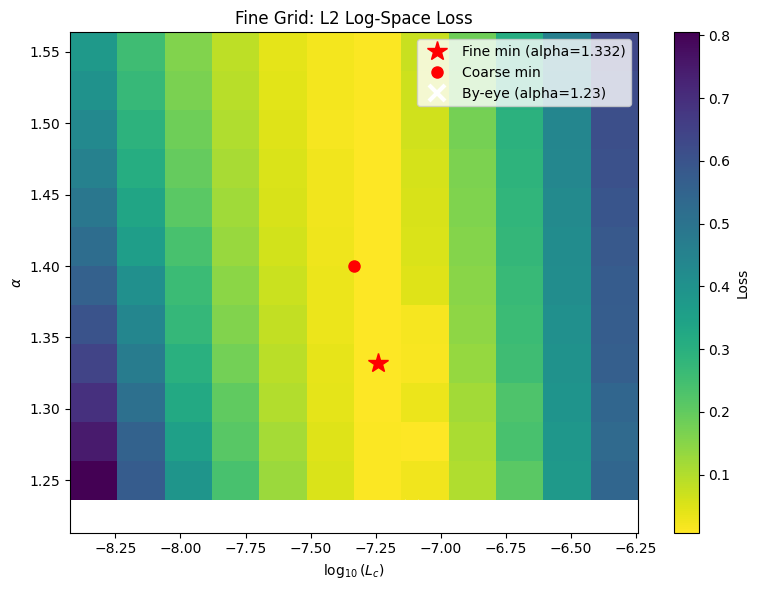

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_fine = loss_fine.copy()
plot_fine[~np.isfinite(plot_fine)] = np.nan

im = ax.pcolormesh(log_Lc_fine, alpha_fine, plot_fine,
                    shading='auto', cmap='viridis_r')
ax.plot(best_log_Lc_f, best_alpha_f, 'r*', markersize=15,
        label=f'Fine min (alpha={best_alpha_f:.3f})')
ax.plot(best_log_Lc_c, best_alpha_c, 'ro', markersize=8,
        label=f'Coarse min')
ax.plot(log_Lc_eye, alpha_eye, 'wx', markersize=12, mew=3,
        label=f'By-eye (alpha={alpha_eye})')
ax.set_xlabel(r"$\log_{10}(L_c)$")
ax.set_ylabel(r"$\alpha$")
ax.set_title("Fine Grid: L2 Log-Space Loss")
plt.colorbar(im, ax=ax, label="Loss")
ax.legend()
plt.tight_layout()
plt.savefig("figures/mle_fine_grid.png", dpi=150)
plt.show()

## Nelder-Mead Optimization

Polish the grid search result with derivative-free optimization.

In [68]:
def objective(params):
    return compute_loss(params[0], params[1], q)

x0 = [best_alpha_f, best_log_Lc_f]
print(f"Starting Nelder-Mead from: alpha = {x0[0]:.4f}, log10(Lc) = {x0[1]:.4f}")

t0 = time()
result = minimize(
    objective, x0, method='Nelder-Mead',
    options={'xatol': 1e-3, 'fatol': 1e-5, 'maxiter': 80, 'disp': True}
)

alpha_mle = result.x[0]
log_Lc_mle = result.x[1]
Lc_mle = 10**log_Lc_mle

print(f"\nMLE estimates:")
print(f"  alpha = {alpha_mle:.4f}")
print(f"  Lc    = {Lc_mle:.4e}  (log10 = {log_Lc_mle:.4f})")
print(f"  q     = {q} (fixed)")
print(f"  Loss  = {result.fun:.6f}")
print(f"  Converged: {result.success}")
print(f"  Optimization time: {(time()-t0)/60:.1f} min")

Starting Nelder-Mead from: alpha = 1.3318, log10(Lc) = -7.2424
Optimization terminated successfully.
         Current function value: 0.000582
         Iterations: 26
         Function evaluations: 61

MLE estimates:
  alpha = 1.2429
  Lc    = 7.7068e-08  (log10 = -7.1131)
  q     = 0.2 (fixed)
  Loss  = 0.000582
  Converged: True
  Optimization time: 1.1 min


## Comparison: MLE vs By-Eye Fit

Compute the full Silverstein density at both parameter sets and overlay on the empirical histogram.

In [69]:
def frac_excess(eigs, bins, alpha, q, Lc):
    """Fractional excess of empirical histogram over theoretical density."""
    hist, bin_edges = np.histogram(eigs, bins, density=True)
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2

    evals = bin_mids[::-1]
    num_density = silverstein_density(evals, alpha=alpha, q=q, Lc=Lc)
    rho_dict = {z: abs(rho) for z, rho in zip(evals, num_density)}
    zL, zR = end_pts(rho_dict)

    return np.array([
        (z, (hist[i] - abs(rho_dict[z])) / hist[i])
        for i, z in enumerate(bin_mids)
        if zR >= z >= zL and rho_dict[z] is not None
    ])

In [70]:
# Compute theoretical densities on a dense grid for plotting
evals_plot = np.logspace(-8, -2, 300)[::-1]

print("Computing MLE density...")
rho_mle_raw = silverstein_density(evals_plot, alpha=alpha_mle, q=q, Lc=Lc_mle)
rho_mle_dict = {z: abs(r) for z, r in zip(evals_plot, rho_mle_raw) if r is not None}
zL_mle, zR_mle = end_pts(rho_mle_dict)
integral_mle = -np.trapezoid(
    [rho_mle_dict[z] for z in evals_plot if zR_mle >= z >= zL_mle and rho_mle_dict.get(z) is not None],
    [z for z in evals_plot if zR_mle >= z >= zL_mle and rho_mle_dict.get(z) is not None]
)
print(f"  MLE integral check: {integral_mle:.4f}")

print("Computing by-eye density...")
rho_eye_raw = silverstein_density(evals_plot, alpha=alpha_eye, q=q, Lc=Lc_eye)
rho_eye_dict = {z: abs(r) for z, r in zip(evals_plot, rho_eye_raw) if r is not None}
zL_eye, zR_eye = end_pts(rho_eye_dict)
integral_eye = -np.trapezoid(
    [rho_eye_dict[z] for z in evals_plot if zR_eye >= z >= zL_eye and rho_eye_dict.get(z) is not None],
    [z for z in evals_plot if zR_eye >= z >= zL_eye and rho_eye_dict.get(z) is not None]
)
print(f"  By-eye integral check: {integral_eye:.4f}")

Computing MLE density...
  MLE integral check: 0.9934
Computing by-eye density...
  By-eye integral check: nan


Computing MLE fractional excess...
Computing by-eye fractional excess...


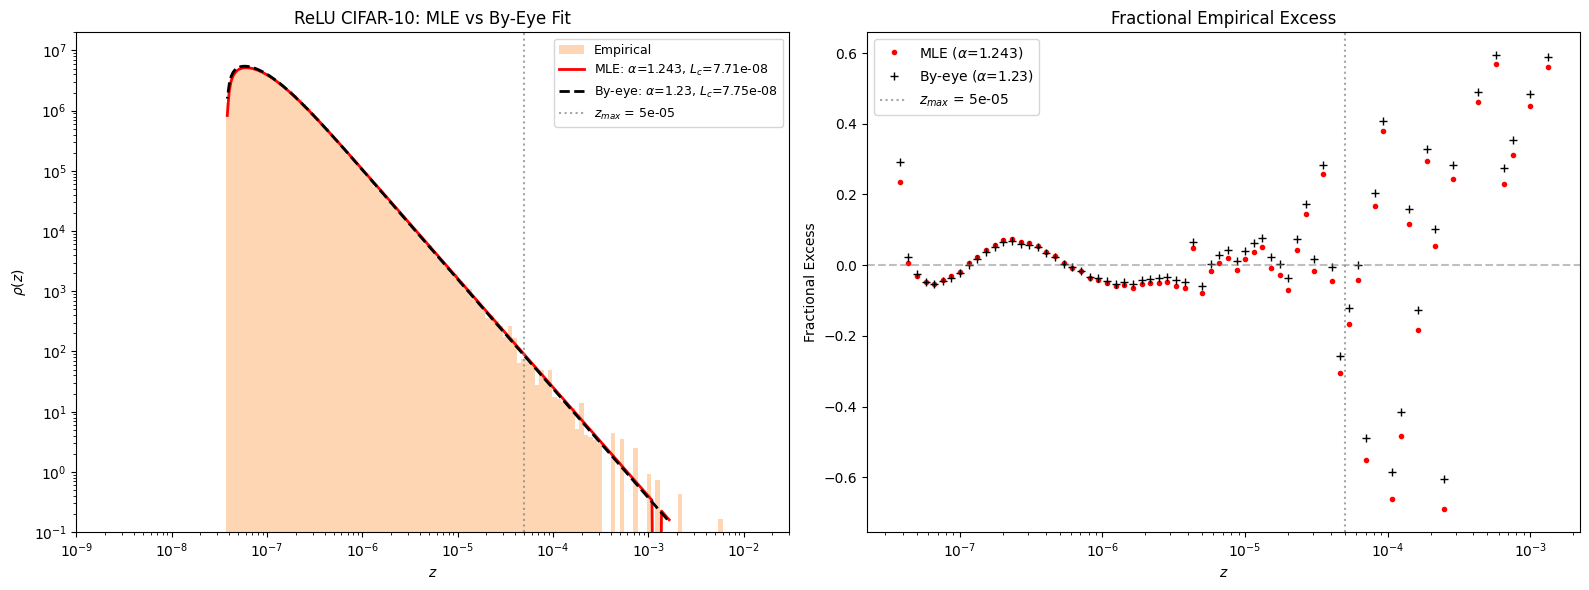

In [71]:
sns.set_palette("magma_r")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Left: Spectral density comparison ---
ax = axes[0]
ax.hist(eigs_relu, bins=np.logspace(-8, -1, 150), density=True,
        alpha=0.6, label="Empirical")

z_mle = [z for z in evals_plot if zR_mle >= z >= zL_mle and z in rho_mle_dict]
ax.plot(z_mle, [rho_mle_dict[z] for z in z_mle],
        'r-', linewidth=2,
        label=rf"MLE: $\alpha$={alpha_mle:.3f}, $L_c$={Lc_mle:.2e}")

z_eye = [z for z in evals_plot if zR_eye >= z >= zL_eye and z in rho_eye_dict]
ax.plot(z_eye, [rho_eye_dict[z] for z in z_eye],
        'k--', linewidth=2,
        label=rf"By-eye: $\alpha$={alpha_eye}, $L_c$={Lc_eye:.2e}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$\rho(z)$")
ax.set_title("ReLU CIFAR-10: MLE vs By-Eye Fit")
ax.set_xlim(1e-9, 3e-2)
ax.set_ylim(1e-1, 2e7)
ax.axvline(Z_MAX, color='gray', linestyle=':', alpha=0.7, label=f"$z_{{max}}$ = {Z_MAX:.0e}")
ax.legend(fontsize=9)

# --- Right: Fractional excess comparison ---
ax = axes[1]
excess_bins = np.logspace(-8, -2, 100)

print("Computing MLE fractional excess...")
excess_mle = frac_excess(eigs_relu, excess_bins, alpha=alpha_mle, q=q, Lc=Lc_mle)

print("Computing by-eye fractional excess...")
excess_eye = frac_excess(eigs_relu, excess_bins, alpha=alpha_eye, q=q, Lc=Lc_eye)

ax.plot(excess_mle[:, 0], excess_mle[:, 1], 'r.', markersize=6,
        label=rf"MLE ($\alpha$={alpha_mle:.3f})")
ax.plot(excess_eye[:, 0], excess_eye[:, 1], 'k+', markersize=6,
        label=rf"By-eye ($\alpha$={alpha_eye})")
ax.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax.axvline(Z_MAX, color='gray', linestyle=':', alpha=0.7, label=f"$z_{{max}}$ = {Z_MAX:.0e}")
ax.set_xscale('log')
ax.set_xlabel(r"$z$")
ax.set_ylabel("Fractional Excess")
ax.set_title("Fractional Empirical Excess")
ax.legend()

plt.tight_layout()
plt.savefig("figures/mle_comparison.png", dpi=150)
plt.show()

## Summary

In [72]:
# Compute losses at both parameter sets for comparison
loss_at_mle = compute_loss(alpha_mle, log_Lc_mle, q)
loss_at_eye = compute_loss(alpha_eye, log_Lc_eye, q)

# Express Lc as prefactor * M^(-alpha) for interpretability
prefactor_mle = Lc_mle / M**(-alpha_mle)
prefactor_eye = Lc_eye / M**(-alpha_eye)

print("=" * 65)
print("PARAMETER COMPARISON: MLE vs BY-EYE")
print("=" * 65)
print(f"{'Parameter':<25} {'By-Eye':<20} {'MLE':<20}")
print("-" * 65)
print(f"{'alpha':<25} {alpha_eye:<20.4f} {alpha_mle:<20.4f}")
print(f"{'Lc':<25} {Lc_eye:<20.4e} {Lc_mle:<20.4e}")
print(f"{'log10(Lc)':<25} {log_Lc_eye:<20.4f} {log_Lc_mle:<20.4f}")
print(f"{'Lc prefactor (Lc/M^-a)':<25} {prefactor_eye:<20.4e} {prefactor_mle:<20.4e}")
print(f"{'q (fixed)':<25} {q:<20.4f} {q:<20.4f}")
print("-" * 65)
print(f"{'L2 log-space loss':<25} {loss_at_eye:<20.6f} {loss_at_mle:<20.6f}")
print(f"{'Density integral':<25} {integral_eye:<20.4f} {integral_mle:<20.4f}")
print("=" * 65)

PARAMETER COMPARISON: MLE vs BY-EYE
Parameter                 By-Eye               MLE                 
-----------------------------------------------------------------
alpha                     1.2300               1.2429              
Lc                        7.7546e-08           7.7068e-08          
log10(Lc)                 -7.1104              -7.1131             
Lc prefactor (Lc/M^-a)    6.4500e-03           7.2189e-03          
q (fixed)                 0.2000               0.2000              
-----------------------------------------------------------------
L2 log-space loss         0.000650             0.000582            
Density integral          nan                  0.9934              
